# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Firman Maulana
- **Email:** mfirman4674@gmail.com
- **ID Dicoding:** -

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import kagglehub
import shutil
import random
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

from torchvision import datasets, transforms

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Data Loading

In [2]:
# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotion-recognition-dataset


Jumlah gambar per kelas: {'Neutral': 3947, 'Sad': 3824, 'Happy': 3637}
Rata-rata ukuran gambar: 557x557


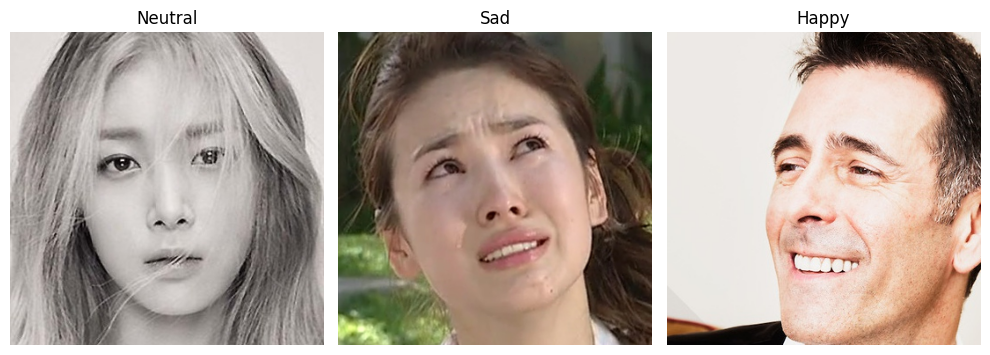

In [3]:
# Path dataset
dataset_path = "/kaggle/input/emotion-recognition-dataset/dataset"
selected_classes = ['Neutral', 'Sad', 'Happy']

image_counts = {}
widths, heights = [], []
example_images = {}

# Loop per kelas
for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    image_counts[cls] = len(images)

    # Ambil 1 gambar contoh
    img_path = os.path.join(class_path, images[0])
    with Image.open(img_path) as img:
        widths.append(img.width)
        heights.append(img.height)
        example_images[cls] = img.copy()

# Cetak info
print("Jumlah gambar per kelas:", image_counts)
print(f"Rata-rata ukuran gambar: {sum(widths)//len(widths)}x{sum(heights)//len(heights)}")

# Tampilkan 1 gambar per kelas
plt.figure(figsize=(10, 4))
for i, (label, img) in enumerate(example_images.items()):
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

#### Split Dataset

In [4]:
# Parameter
IMG_SIZE = 48
BATCH_SIZE = 64
CLASSES = ['Neutral', 'Sad', 'Happy']
SPLIT_RATIO = (0.7, 0.15, 0.15)

#Split dataset ke dalam folder train/val/test
SOURCE_DIR = "/kaggle/input/emotion-recognition-dataset/dataset"
TARGET_BASE = "/kaggle/working/emotion-dataset-simplified"

for cls in CLASSES:
    src_folder = os.path.join(SOURCE_DIR, cls)
    all_files = os.listdir(src_folder)
    random.shuffle(all_files)

    total = len(all_files)
    train_end = int(total * SPLIT_RATIO[0])
    val_end = train_end + int(total * SPLIT_RATIO[1])

    splits = {
        'train': all_files[:train_end],
        'val': all_files[train_end:val_end],
        'test': all_files[val_end:]
    }

    for split_name, files in splits.items():
        dst_folder = os.path.join(TARGET_BASE, split_name, cls)
        os.makedirs(dst_folder, exist_ok=True)
        for file in tqdm(files, desc=f"Copying {cls} to {split_name}"):
            shutil.copy(os.path.join(src_folder, file), os.path.join(dst_folder, file))

Copying Happy to test: 100%|██████████| 561/561 [00:00<00:00, 881.20it/s]


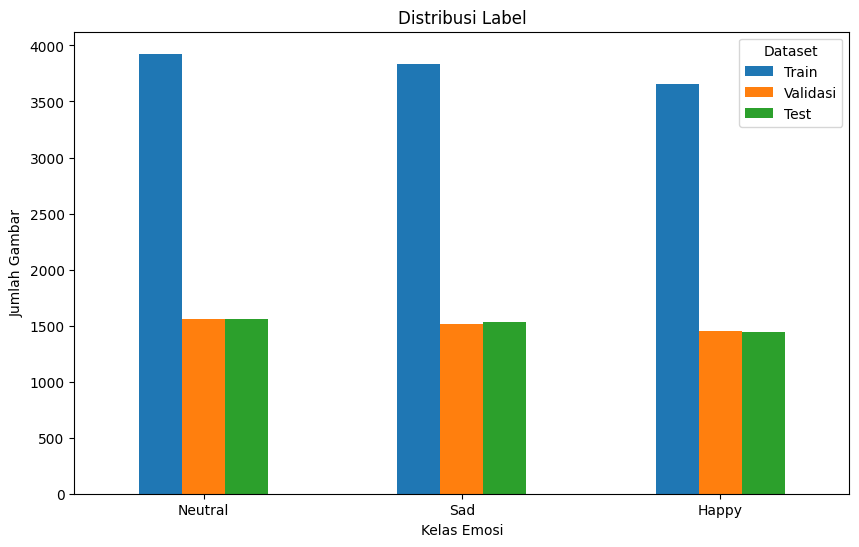

In [5]:
# Menghitung jumlah gambar per kelas dalam setiap set (train, val, test)
train_counts = {}
val_counts = {}
test_counts = {}

for cls in CLASSES:
    train_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "train", cls)))
    val_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "val", cls)))
    test_counts[cls] = len(os.listdir(os.path.join(TARGET_BASE, "test", cls)))

# Membuat DataFrame untuk visualisasi
df_dist = pd.DataFrame({
    'Kelas': CLASSES,
    'Train': train_counts.values(),
    'Validasi': val_counts.values(),
    'Test': test_counts.values()
})

# Menampilkan distribusi label menggunakan bar plot
df_dist.plot(x='Kelas', kind='bar', figsize=(10, 6))
plt.title('Distribusi Label')
plt.xlabel('Kelas Emosi')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.show()

In [6]:
#Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

#Load Data
train = train_datagen.flow_from_directory(
     os.path.join(TARGET_BASE, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True
)

val = val_test_datagen.flow_from_directory(
     os.path.join(TARGET_BASE, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

test = val_test_datagen.flow_from_directory(
     os.path.join(TARGET_BASE, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Found 11413 images belonging to 3 classes.
Found 4526 images belonging to 3 classes.
Found 4531 images belonging to 3 classes.


## Modelling

In [7]:
#Model CNN
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,739 (1.85 MB)

 Trainable params: 484,739 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

In [10]:
#Training
history = model.fit(
    train,
    epochs=40,
    validation_data=val,
    callbacks=callbacks
)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 411ms/step - accuracy: 0.3601 - loss: 1.0848 - val_accuracy: 0.6374 - val_loss: 0.7921
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 381ms/step - accuracy: 0.6548 - loss: 0.7427 - val_accuracy: 0.6834 - val_loss: 0.6836
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 375ms/step - accuracy: 0.7069 - loss: 0.6341 - val_accuracy: 0.7293 - val_loss: 0.6021
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 387ms/step - accuracy: 0.7360 - loss: 0.5755 - val_accuracy: 0.7506 - val_loss: 0.5392
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 379ms/step - accuracy: 0.7492 - loss: 0.5506 - val_accuracy: 0.7559 - val_loss: 0.5405
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 384ms/step - accuracy: 0.7614 - loss: 0.5288 - val_accuracy: 0.7760 - val_loss: 0.4908
Epoch 7/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 68s 380ms/step - accuracy: 0.7667 - loss: 0.5046 - val_accuracy: 0.7877 - val_loss: 0.4790
Epoch 8/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 377ms/step - accuracy: 0.7907 - loss: 0

In [11]:
test_loss, test_acc = model.evaluate(test)
print(f"Test Accuracy: {test_acc:.2%}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.9770 - loss: 0.0726
Test Accuracy: 95.34%


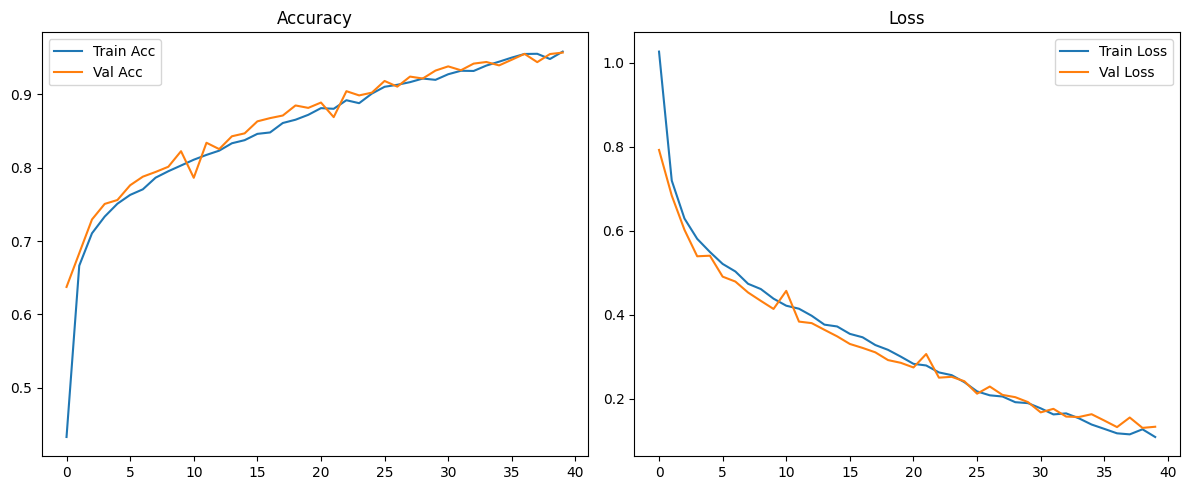

In [12]:
# --- PLOTTING ---
plt.figure(figsize=(12, 5))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step


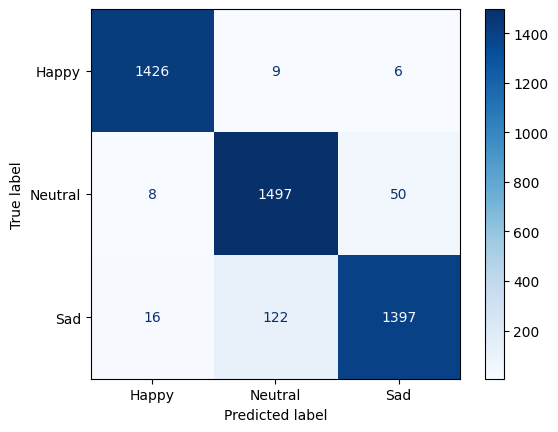

In [13]:
# prompt: tampilkan confussion matriks nya

y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test.classes, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.show()


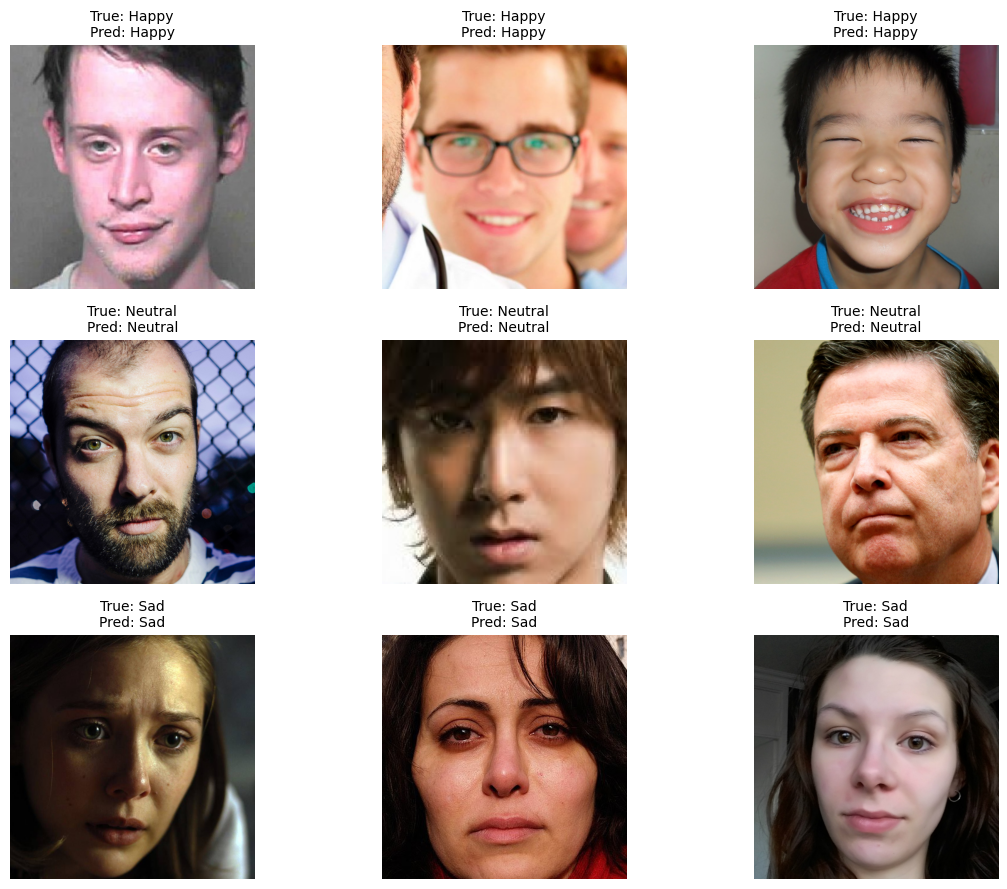

In [14]:
# Ambil label asli dari generator
y_true = test.classes
filenames = test.filenames
class_names = list(test.class_indices.keys())
test_dir = test.directory  # Path folder utama data test

# Dictionary untuk menyimpan maksimal 3 gambar per kelas yang diprediksi dengan benar
found_classes = {label: [] for label in class_names}

# Loop semua gambar dan pilih 3 gambar per kelas yang prediksinya benar
for i in range(len(filenames)):
    true_idx = y_true[i]
    pred_idx = y_pred[i]

    if true_idx == pred_idx:  # Prediksi benar
        true_label = class_names[true_idx]
        pred_label = class_names[pred_idx]

        # Simpan maksimal 3 gambar per kelas
        if len(found_classes[true_label]) < 3:
            found_classes[true_label].append((filenames[i], pred_label))

# Tampilkan gambar asli dengan label asli dan prediksi
plt.figure(figsize=(12, len(class_names) * 3))
count = 1

for label in class_names:
    for img_name, pred_label in found_classes[label]:
        img_path = os.path.join(test_dir, img_name)
        img = Image.open(img_path)

        plt.subplot(len(class_names), 3, count)
        plt.imshow(img)
        plt.title(f"True: {label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
        count += 1

plt.tight_layout()
plt.show()


## Konversi Model

In [15]:
# Menyimpan model sebagai savedmodel
tf.saved_model.save(model, 'saved_model')

In [16]:
pip install tensorflowjs

In [17]:
import tensorflowjs as tfjs
import os

# Buat folder output
os.makedirs('tfjs_model', exist_ok=True)

# Simpan model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file


In [18]:
# Menyimpan model sebagai tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

os.makedirs('tflite', exist_ok=True)
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# Buat file label.txt dari class_names
with open('tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")


Saved artifact at '/tmp/tmpyembcihj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137279715009616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715010960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715010576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715009808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715010768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715003856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715013456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715012880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715014224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137279715015184: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Inference (Optional)

In [19]:
from keras.layers import TFSMLayer

# Load model dengan TFSMLayer
model = TFSMLayer('saved_model', call_endpoint='serving_default')

# Contoh class_names
class_names = ['Happy', 'Neutral', 'Sad']

# Fungsi untuk prediksi
def predict_image(img_path, model, target_size=(48, 48)):
    img = image.load_img(img_path, target_size=target_size, color_mode='grayscale')  # Sesuaikan jika RGB
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    return class_names[predicted_class], float(confidence)


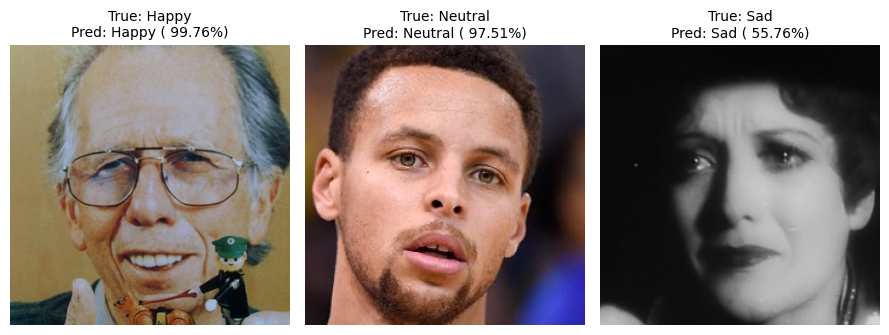

In [20]:
# Konfigurasi
class_names = list(test.class_indices.keys())  # Nama kelas dari generator
test_dir = test.directory  # Path folder test

# Fungsi prediksi
def predict_image(img_path, model, target_size=(48, 48)):
    img = image.load_img(img_path, target_size=target_size, color_mode='grayscale')  # atau 'rgb'
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    output = model(img_array)
    prediction = next(iter(output.values())).numpy()  # Ambil tensor & convert ke numpy
    pred_index = np.argmax(prediction)
    confidence = np.max(prediction)

    return class_names[pred_index], float(confidence)

# Visualisasi 1 gambar per kelas
plt.figure(figsize=(len(class_names) * 3, 4))

for idx, label in enumerate(class_names):
    label_dir = os.path.join(test_dir, label)
    img_list = [f for f in os.listdir(label_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if img_list:
        img_path = os.path.join(label_dir, img_list[0])
        pred_label, confidence = predict_image(img_path, model)

        # Tampilkan gambar asli (warna)
        img = Image.open(img_path)
        plt.subplot(1, len(class_names), idx + 1)
        plt.imshow(img)
        plt.title(f"True: {label}\nPred: {pred_label} ({confidence: .2%})", fontsize=10)
        plt.axis('off')

plt.tight_layout()
plt.show()
